In [1]:
from google.colab import files
files.upload()

Saving text_helpers.py to text_helpers.py


{'text_helpers.py': b'## This Lab is made with inspiration & code snippets of:\n##     - https://github.com/yxtay/char-rnn-text-generation\n##     - https://d2l.ai/chapter_recurrent-modern/lstm.html\n##     - https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html\n\nimport numpy as np\nimport random\nimport string\nimport collections\nimport re\n\n\ndef count_corpus(tokens):  # @save\n    """Count token frequencies."""\n    # Here `tokens` is a 1D list or 2D list\n    if len(tokens) == 0 or isinstance(tokens[0], list):\n        # Flatten a list of token lists into a list of tokens\n        tokens = [token for line in tokens for token in line]\n    return collections.Counter(tokens)\n\n\ndef tokenize(lines, token=\'word\'):  # @save\n    """Split text lines into word or character tokens."""\n    if token == \'word\':\n        #return [line.split() for line in lines]\n        return [ (word + \' \') for line in lines for word in line.split()]\n    elif token == \'char\':\n    

In [2]:
files.upload()

Saving williamfaulkner.txt to williamfaulkner.txt


{'williamfaulkner.txt': b'THE SOUND AND THE FURY\r\n\r\n\r\n\r\n\r\n                          APRIL SEVENTH, 1928\r\n\r\n\r\nThrough the fence, between the curling flower spaces, I could see them\r\nhitting. They were coming toward where the flag was and I went along the\r\nfence. Luster was hunting in the grass by the flower tree. They took the\r\nflag out, and they were hitting. Then they put the flag back and they\r\nwent to the table, and he hit and the other hit. Then they went on, and\r\nI went along the fence. Luster came away from the flower tree and we\r\nwent along the fence and they stopped and we stopped and I looked\r\nthrough the fence while Luster was hunting in the grass.\r\n\r\n\xe2\x80\x9cHere, caddie.\xe2\x80\x9d He hit. They went away across the pasture. I held to the\r\nfence and watched them going away.\r\n\r\n\xe2\x80\x9cListen at you, now.\xe2\x80\x9d Luster said. \xe2\x80\x9cAint you something, thirty-three\r\nyears old, going on that way. After I done went all

In [3]:
import math
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import text_helpers as th

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

input_file = "williamfaulkner.txt"
corpus, vocab = th.load_corpus(input_file, token_type="char")
VOCAB_SIZE = len(vocab)
print("corpus len:", len(corpus), "vocab size:", VOCAB_SIZE)

BATCH_SIZE = 128
SEQ_LEN = 256
num_batches = (len(corpus) - 1) // (BATCH_SIZE * SEQ_LEN)

data_iter = th.batch_generator(
    th.encode_text(corpus, char2id=vocab),
    batch_size=BATCH_SIZE,
    seq_len=SEQ_LEN,
    vocab=vocab
)

device: cuda
corpus len: 504311 vocab size: 82


In [4]:
class MyCharRNN(nn.Module):
    def __init__(self, vocab_size, emb_size=64, hidden_size=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.W_xh = nn.Parameter(torch.empty(emb_size, hidden_size))
        self.W_hh = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_h  = nn.Parameter(torch.zeros(hidden_size))

        self.W_hy = nn.Parameter(torch.empty(hidden_size, vocab_size))
        self.b_y  = nn.Parameter(torch.zeros(vocab_size))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W_xh)
        nn.init.orthogonal_(self.W_hh)
        nn.init.xavier_uniform_(self.W_hy)

    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.W_hh.shape[0], device=device)

    def forward(self, x, h=None):
        """
        x: LongTensor [B, T]
        h: FloatTensor [B, H]
        returns:
          logits: [B, T, V]
          h: [B, H]
        """
        B, T = x.shape
        if h is None:
            h = self.init_hidden(B, x.device)

        emb = self.emb(x)  # [B, T, E]
        logits_steps = []

        for t in range(T):
            x_t = emb[:, t, :]                      # [B, E]
            h = torch.tanh(x_t @ self.W_xh + h @ self.W_hh + self.b_h)  # [B, H]
            y_t = h @ self.W_hy + self.b_y          # [B, V]
            logits_steps.append(y_t)

        logits = torch.stack(logits_steps, dim=1)   # [B, T, V]
        return logits, h

In [5]:
def generate_text(model, vocab, seed, length=300, top_n=10):
    model.eval()
    ids = torch.tensor([vocab[ch] for ch in seed], dtype=torch.long, device=device).unsqueeze(0)  # [1, T]
    h = model.init_hidden(batch_size=1, device=device)
    with torch.no_grad():
        logits, h = model(ids, h)

        generated = list(seed)
        last_id = ids[0, -1].view(1, 1)

        for _ in range(length):
            logits, h = model(last_id, h)  # [1, 1, V]
            probs = torch.softmax(logits[0, 0], dim=0).detach().cpu().numpy()

            next_id = th.sample_from_probs(probs, top_n=top_n)
            next_ch = vocab.to_tokens(int(next_id))

            generated.append(next_ch)
            last_id = torch.tensor([[next_id]], dtype=torch.long, device=device)

    return "".join(generated)

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

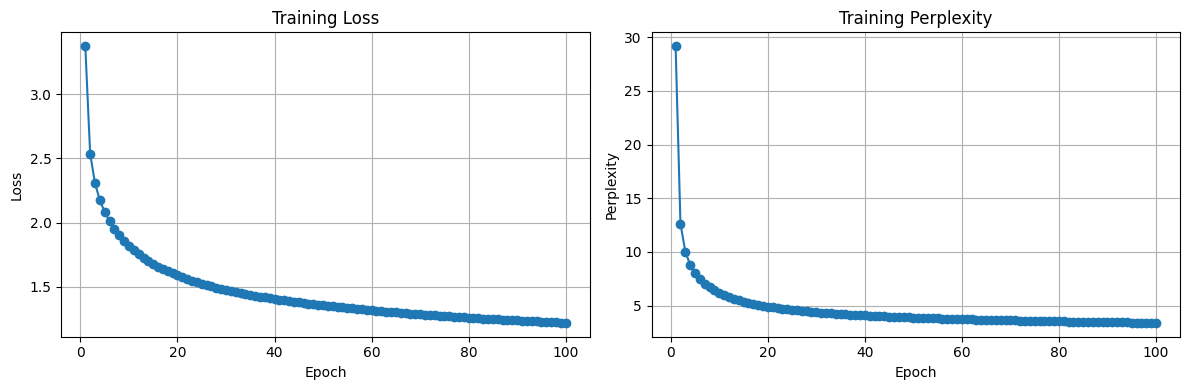

epoch 100: loss=1.2199, ppl≈3.39
 says. She jerke at me
writhounded out and put her much weather,” she says, “How can didn’t have along the fart be if it dar but I could seem now. Then all to throw after it.”

We stow,
she could

“You know much, hal
--------------------------------------------------------------------------------


In [7]:
model = MyCharRNN(VOCAB_SIZE, emb_size=64, hidden_size=256).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 100
CLIP = 1.0

train_losses = []
train_ppls = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    h = None
    total_loss = 0.0

    for b in range(num_batches):
        x_np, y_np = next(data_iter)        # x,y: [B, T]
        x = torch.tensor(x_np, dtype=torch.long, device=device)
        y = torch.tensor(y_np, dtype=torch.long, device=device)

        if h is not None:
            h = h.detach()  # truncated BPTT

        opt.zero_grad()
        logits, h = model(x, h)  # [B, T, V]
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), y.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        opt.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    ppl = math.exp(avg_loss) if avg_loss < 20 else float("inf")
    train_losses.append(avg_loss)
    train_ppls.append(ppl)
    clear_output(wait=True)

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_ppls, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Training Perplexity")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"epoch {epoch:02d}: loss={avg_loss:.4f}, ppl≈{ppl:.2f}")

    # пример генерации
    seed = "".join(th.generate_seed(corpus))
    print(generate_text(model, vocab, seed=seed, length=200, top_n=10))
    print("-" * 80)

In [10]:
SAVE_PATH = "/content/char_rnn_model.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "vocab": vocab,
    "emb_size": 64,
    "hidden_size": 256,
}, SAVE_PATH)

In [11]:
files.download(SAVE_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>